# Nonlinear Analysis
## Region of Attraction Estimation for Polynomial Dynamics

Joe Carpinelli <br> May 12th, 2020


In [34]:
# Code Imports

from scipy import optimize, integrate
from sympy import init_printing, latex
init_printing()

import astropy.units as units
import scipy as sci
import sympy as sym
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Markdown, Latex, display

import itertools
import multiprocessing

## Use from-scratch state equations
debugging = False

### Why is Nonlinear Analysis Important?

* Flight control validation commonly "relies heavily on linear analyses and nonlinear, high-fidelity simulations" \[1\]. These two analysis methods do not necessarily capture all of the dynamics in a system

* Dynamics can affect real stability margins if they are not included in linear or simulation analysis

* "The F/A-18 Hornet aircraft with the original flight control law exhibited a nonlinear out-of-control phenomenon known as the falling-leaf mode \[2\].

## Topic -  Nonlinear ROA Analysis for NASA's GTM

This project summarizes, and at times replicates results authored by Abhijt Chakraborty et al \[1\]

* Flight control dynamics near a level-flight trim condition are investigated for NASA's Generic Transport Model aircraft (GTM) 

* A method for finding an estimate for the region of attraction is introduced

* A polynomial approximation for NASA's GTM is introduced


### NASA's Generic Transport Model aircraft

* "NASA's Generic Transport Model (GTM) describes a remote-controlled 5.5 percent scale commercial aircraft" \[1\]

* Used for testing by NASA AirSTAR (Airborn Subscale Transport Aircraft Research) \[1\]\[5\]


[GTM Flight](https://www.youtube.com/watch?time_continue=26&v=_3JSRvaTRIQ&feature=emb_logo)

## Nonlinear Dynamics

### Variables
| Symbol             | Title                       | Units                                  |
| ---                | ---                         | ---                                    |
| $V$                | Air Speed $(x_1)$           | $\frac{\text{Meter}}{\text{Second}}$   |
| $\alpha$           | Angle of Attack $(x_2)$     | Radians                                |
| $q$                | Pitch Rate $(x_3)$          | $\frac{\text{Radians}}{\text{Second}}$ |
| $\theta$           | Pitch Angle $(x_4)$         | Radians                                |
| $\delta_{elev}$    | Elevator Deflection $(u_1)$ | Radians                                |
| $\delta_{th}$      | Engine Throttle $(u_2)$     | %                                      |
| $T(\delta_{th})$   | Thrust due to Single Engine | Newtons                                |
| $T_{x,z}(\delta_{th})$   | Projection of Thrust Along Body $x,z$ | Newtons                                |
| $T_m(\delta_{th})$   | Pitching Moment due to Thrust | Newton $\cdot$ Meters                               |
| $D$                | Drag Force                  | Newtons                                |
| $L$                | Lift Force                  | Newtons                                |
| $M$                | Aerodynamic Pitching Moment | Newton $\cdot$ Meters                   |
| $\bar{q}$          | Dynamic Pressure            | $\frac{\text{Newtons}}{\text{Meter}^2}$|
| $\hat{q}$          | Normalized Pitch Rat        | Unitless                               |

### Constants
| Symbol             | Title                       | Units                                  | Value |
| ---                | ---                         | ---                                    | --- | 
| $S$                | Wing Area                   | Meter${}^2$                            |$0.5483$ |
| $\bar{c}$          | Mean Aerodynamic Chord      | Meter                                  |$0.2790$ |
| $m$                | Mass                        | Kg                                     |$22.5$   |
| $I_{yy}$           | Pitch Axis Moment of Inertia| Kg $\cdot$ Meter${}^2$                 |$5.768$  |
| $\rho$             | Air Density                 | $\frac{\text{Kg}}{\text{Meter}^3}$     |$1.224$  |
| $g$                | Gravity Constant            | $\frac{\text{Meter}}{\text{Second}^2}$ |$9.810$  |
| $n_{ENG}$          | Number of Engines           | Unitless                               |$2$      |
| $\epsilon_{2}$   | Angle b/w Engine and Body Axes | Radians | $0.0375$ |
| $\epsilon_3$ | Angle b/w Engine and Body Axes | Radians | $-0.0294$ | 
| $r_x$ | Thrust moment arm in $x$ | Meters | $0.1371$ | 
| $r_z$ | Thrust moment arm in $z$ | Meters | $0.0907$ | 

## Nonlinear Dynamics

### State Equations

$$ 
    \dot{x} = \begin{bmatrix}
        \frac{1}{m}
            \left(
                -D - m g \sin{(\theta - \alpha)} + T_x \cos{\alpha} + T_z \sin{\alpha}
            \right) \\
        \frac{1}{m V}
            \left(
                -L + m g \cos{(\theta - \alpha)} - T_x \sin{\alpha} + T_z \cos{\alpha}
            \right) + q \\
        \frac{M + T_m}{Iyy} \\
        q
    \end{bmatrix}
$$



In [2]:
## Set up symbolic variables

x1, x2, x3, x4, u1, u2 = sym.symbols('x1, x2, x3, x4, u1, u2')

### Aerodynamic Terms

$$
    \begin{align}
        \bar{q} &= \frac{1}{2} \rho V^2 \\ \\
        \hat{q} &= \frac{\bar{c}}{2 V} q \\ \\ 
        D &= \bar{q}\, S\, C_D\, (\alpha, \delta_{elev}, \hat{q}) \tag{5} \\ \\
        L &= \bar{q}\, S\, C_L\, (\alpha, \delta_{elev}, \hat{q}) \tag{6} \\ \\\
        M &= \bar{q}\, \bar{c}\, S\, C_m\, (\alpha, \delta_{elev}, \hat{q}) \tag{7} 
    \end{align}
$$

### Thrust Terms

$$ T_x(\delta_{th}) = n_{ENG} T(\delta_{th}) \cos{(\epsilon_2)} \cos{(\epsilon_3)} \tag{8}$$ 

$$ T_z(\delta_{th}) = n_{ENG} T(\delta_{th}) \sin{(\epsilon_2)} \cos{(\epsilon_3)} \tag{9}$$

$$ T_m(\delta_{th}) = r_z T_x(\delta_{th}) - r_x T_z(\delta_{th}) \tag{10}$$ 

In [3]:
## Add thrust terms to code

# Number of engines
n_eng = 2

# Engine thrust offsets
epsilon2 = 0.0375
epsilon3 = -0.0294

# Thrust moment arms
rx = 0.1371
rz = 0.0907

# Approx. thrust polynomial - defined (11)
T = -8.751e-6*u2**3 + 5.115e-3*u2**2 + 3.673e-1*u2 + 4.825

# X and Z components of total thrust
Tx = n_eng*T*sym.cos(epsilon2)*sym.cos(epsilon3)
Tz = n_eng*T*sym.sin(epsilon2)*sym.cos(epsilon3)

# Pitching moment due to both engines
Tm = rz*Tx - rx*Tz

## Nonlinear Dynamics

### Nonlinear State Space Representation

$$ 
    x = \begin{bmatrix} V \\ \alpha \\ q \\ \theta \end{bmatrix},\ \ \ 
    u = \begin{bmatrix} \delta_{elev} \\ \delta_{th} \end{bmatrix} 
$$

$$ 
    \dot{x} = \begin{bmatrix}
        \frac{1}{m}
            \left(
                -D - m g \sin{(x_4 - x_2)} + T_x \cos{x_2} + T_z \sin{x_2}
            \right) \\
        \frac{1}{m x_1}
            \left(
                -L + m g \cos{(x_4 - x_2)} - T_x \sin{x_2} + T_z \cos{x_2}
            \right) + x_3 \\
        \frac{M + T_m}{Iyy} \\
        x_3
    \end{bmatrix}
$$

### Region of Attraction Estimation

* "The ROA of an asymptotically stable equilibrium point is the set of initial conditions whose state trajectories converge back to the equilibrium" \[2\]\[3\].

* Finding the _exact_ region of attraction is hard, so instead we typically find invariant subsets of the region of attraction

* We've already learned one way to (roughly) estimate the region of attraction

### Conservative ROA Estimate: Lyapunov

|Lemma 1 \[4\]|
|-|
| <img src=media/lemma1/lemma1.png width=500 /> |

### Proposed ROA Estimation Method

* Computing the exact ROA is difficult. Instead, upper and lower bounds for the ROA can be found \[1\].

* If the upper and lower bounds are sufficiently close, then we have confidence in the ROA estimate

* Existing optimization algorithms can be used to more efficiently solve for the ROA estimate

To simplify the computations required to reach these upper and lower bounds, some assumptions are made:

1. Only ellipsoidal ROA estimates are searched

2. Existing optimization software \[7\]\[8\], which requires __low-order polynomial__ nonlinear dynamics with no more than 8-10 states \[1\], is used to more efficiently solve for ROA bounds



## Polynomial Approximations

$$ 
    \dot{x} = \begin{bmatrix}
        \frac{1}{m}
            \left(
                -D - m g \sin{(\theta - \alpha)} + T_x \cos{\alpha} + T_z \sin{\alpha}
            \right) \\
        \frac{1}{m V}
            \left(
                -L + m g \cos{(\theta - \alpha)} - T_x \sin{\alpha} + T_z \cos{\alpha}
            \right) + q \\
        \frac{M + T_m}{Iyy} \\
        q
    \end{bmatrix}
$$

The following terms are approximated by low-order polynomials: \[1\]

1. Trigonometric functions: $\sin{(\alpha)},\ \cos{(\alpha)}$, <br>$\sin{(\theta - \alpha)},\ \cos{(\theta- \alpha)}$

2. Engine model: $T(\delta_{th})$

3. Rational dependence on speed: $\frac{1}{V}$

4. Aerodynamic coefficients: $C_D,\ C_L,\ C_m$


#### Polynomial Approximations: Trigonometric Functions

We get polynomial approximations for $\sin$ and $\cos$ terms for free, with __Taylor Series Expansions__.

$$ 
    \begin{align}
        \sin{(z)} & \approxeq z - \frac{z^3}{3!}  \ \ \ \text{ for } z \ \text{in Radians} \\
        & \implies \sin{(\alpha)} \approxeq \alpha - \frac{1}{6}\alpha^3 \\
        & \implies \sin{(\theta - \alpha)} \approxeq (\theta - \alpha) - \frac{1}{6}(\theta - \alpha)^3 \\
    \end{align}
$$

$$ 
    \begin{align}
        \cos{(z)} & \approxeq z - \frac{1}{2!} z^2  \ \ \ \text{ for } z \ \text{in Radians} \\
        & \implies \cos{(\alpha)} \approxeq \alpha - \frac{1}{2}\alpha^2 \\
        & \implies \cos{(\theta - \alpha)} \approxeq (\theta - \alpha) - \frac{1}{2}(\theta - \alpha)^2 \\
    \end{align}
$$


In [4]:
## Create polynomial approximation functions for sin/cos

# Sine Approximation
def sin_to_poly(z):
    return z - ((z**3) / 6)

# Cosine Approximation
def cos_to_poly(z):
    return z - ((z**2) / 2)

#### Polynomial Approximations: Engine Model

The ninth-order Engine Model $T(\delta_{th})$ is defined within NASA's GTM model. \[1\]

The authors' used a __least squares technique__ to approximate this ninth-order polynomial as a more managable third-order polynomial.

$$ 
    T(\delta_{th}) \approxeq 
        - 8.751 \times 10^{-6} \delta_{th}^3
        + 5.115 \times 10^{-3} \delta_{th}^2
        + 3.673 \times 10^{-1} \delta_{th}
        + 4.825 \tag{11}
$$ 

#### Polynomial Approximations: Rational dependence on speed

The expression $\frac{1}{V}$ appears in the expressions for $\dot{\alpha} \triangleq \dot{x_2}$, as well as the expression for normalized pitch rate $\hat{q}$.

The authors used also used a __least squares technique__ to approximate $\frac{1}{V}$ as a polynomial \[1\].

$$ \frac{1}{V} \approxeq -5.304 \times 10^{-4} V + 4.699 \times 10^{-2} \tag{12}$$

This can be re-created with some simple Python code.

In [5]:
## Add rational dependence on speed to code

rational_speed_dependence = -5.304e-4*x1 + 4.699e-2

1st Order Parameters:


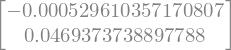

In [6]:
## Curve fit data for 1/V to form f(z) = a*z + b

# Velocity data from 30 to 60 m/s
x_data = np.linspace(30,60,1000000)
y_data= 1 / x_data

# Use SciPy's built-in least squares tool
params, _ = sci.optimize.curve_fit(
    lambda x, a, b: a*x + b, 
    x_data, y_data)

# Print results
sym.pprint('1st Order Parameters:')
display(sym.Matrix(params))

#### Polynomial Approximations: Aerodynamic Coefficients

Body axis aerodynamic coefficients $C_x,\ C_z,\ C_m$ were provided via lookup tables in the NASA GTM model.

To lower approximation errors, $C_x$ and $C_z$ were rotated into lift and drag coordinates \[1\].

$$ 
    \begin{bmatrix}
        C_D \\
        C_L
    \end{bmatrix} = \begin{bmatrix}
        \cos{\alpha} & \sin{\alpha} \\
        -\sin{\alpha} & \cos{\alpha}
    \end{bmatrix} \begin{bmatrix}
        C_x \\ 
        C_z
    \end{bmatrix} \tag{14}
$$

#### Polynomial Approximations: Aerodynamic Coefficients

$C_D$, $C_L$, and $C_m$ were then approximated by third-order polynomial models, which were weighted to be most accurate for low angle-of-attack regions of the state space \[1\].

The drag force, lift force, and pitching moment aerodynamic coefficientsare computed as a sum of three terms: "basic airframe, elevator inputs, and pitch rate" \[1\]

$$ C_*(\alpha, \delta_{elev}, \hat{q}) = 
        C_{*,\alpha}(\alpha)
        + C_{*,\delta_{elev}}(\alpha, \delta_{elev})
        + C_{*,\hat{q}}(\alpha,\hat{q}) $$      
"where $*$ can be replaced by $D$, $L$, $m$ to form the __drag force__, __lift force__, and __pitching moment__ coefficient, respectively" \[1\].

#### Polynomial Approximations: Aerodynamic Coefficients

|Figure 1 - Curve Fitting \[1\]|
|-|
|<img src="media/fig1/fig1_published.png" width=500/>|

#### Polynomial Approximations: Aerodynamic Coefficients \[1\]


$$ 
\begin{align}
&C_{D,\alpha}(\alpha) = - 1.477\alpha^3 + 3.110\alpha^2 - 1.303\times10^{-1}\alpha + 3.060\times10^{-2} \\ 
&C_{D,\delta_{elev}}(\alpha,\delta_{elev}) = - 5.943\times10^{-2}\alpha^2 + 1.435\times10^{-1}\alpha\delta_{elev} + 5.967\times10^{-2}\delta_{elev}^2 \\
&\ \ \ \ \ \ \ \ + 2.661\times10^{-2}\alpha + 2.733\times10^{-2}\delta_{elev} - 1.903\times10^{-3} \\
&C_{D,\hat{q}}(\alpha,\hat{q}) = - 2.917\times10^{-2}\alpha^2 + 33.58\alpha\hat{q} - 151.0\hat{q}^2 - 3.022\times10^{-3}\alpha \\
&\ \ \ \ \ \ \ \ - 9.691\times10^{-1}\hat{q} + 2.221\times10^{-4} \\ \\
&C_{L,\alpha}(\alpha) = 2.141\alpha^3 - 6.575\alpha^2 + 5.298\alpha + 5.337\times10^{-2} \\
&C_{L,\delta_{elev}}(\alpha,\delta_{elev}) = 4.188\times10^{-3}\alpha^2 - 3.438\times10^{-1}\alpha\delta_{elev} + 9.293\times10^{-2}\delta_{elev}^2 \\
&\ \ \ \ \ \ \ \ - 3.497\times10^{-2}\alpha + 4.610\times10^{-1}\delta_{elev} + 2.543\times10^{-3} \\
&C_{L,\hat{q}}(\alpha,\hat{q}) = 2.297\times10^{-2}\alpha^2 - 1.359\alpha\hat{q} - 856.7\hat{q}^2 - 1.673\times10^{-2}\alpha \\
&\ \ \ \ \ \ \ \ + 34.38\hat{q} + 3.703\times10^{-3} \\ \\
&C_{m,\alpha}(\alpha) = - 2.199\times10^{-1}\alpha^3 + 5.912\times10^{-1}\alpha^2 + 1.498\alpha + 1.516\times10^{-1} \\
&C_{m,\delta_{elev}}(\alpha,\delta_{elev}) = 1.263\alpha\delta_{elev} - 1.887\delta_{elev} \\
&C_{m,\hat{q}}(\alpha,\hat{q}) = -41.24\hat{q}
\end{align}
$$



In [7]:
## Add aerodynamic terms to code

# Wing area 
S = 0.5483

# Mean aerodynamic chord
c_bar = 0.2790

# Mass
m = 22.50

# Pitch axis moment of inertia
Iyy = 5.768

# Air density
rho = 1.224

# Gravity constant
g = 9.810

# Normalized pitch rate (unitless)
q_hat = (c_bar / 2) * rational_speed_dependence * x3

# Dynamic pressure
q_bar = (rho/2)*x1**2

## Aerodynamic coefficients, found in
## A.1 [1]

# Drag coefficient
C_D = -1.477*x2**3 + 3.110*x2**2 - 1.303e-1*x2 + 3.060e-2\
- 5.943e-2*x2**2 + 1.435e-1*x2*u1 + 5.967e-2*u1**2 + 2.661e-2*x2 + 2.733e-2*u1 - 1.903e-3\
- 2.197e-2*x2**2 + 33.58*x2*q_hat - 151.0*q_hat**2 - 3.022e-3*x2 - 9.691e-1*q_hat + 2.221e-4

# Lift coefficient
C_L = 2.141*x2**3 - 6.575*x2**2 + 5.298*x2 + 5.337e-2\
+ 4.188e-3*x2**2 - 3.438e-1*x2*u1 + 9.293e-2*u1**2 - 3.497e-2*x2 + 4.610e-1*u1 + 2.543e-3\
+ 2.297e-2*x2**2 - 1.359*x2*q_hat - 856.7*q_hat**2 - 1.673e-2*x2 + 34.38*q_hat + 3.703e-3

# Pitching moment coefficient
C_m = -2.199e-1*x2**3 + 5.912e-1*x2**2 - 1.498*x2 + 1.516e-1\
+ 1.263*x2*u1 - 1.887*u1\
- 41.24*q_hat # + 5.318*q_hat**3 # causes lower stability margin (34) [1]

# Drag force
D = q_bar*S*C_D

# Lift force
L = q_bar*S*C_L

# Pitching moment
M = q_bar*S*c_bar*C_m

## Polynomial State Space Model

Recall the 4-state longitudinal dynamics:
$$ 
    \dot{x} = \begin{bmatrix}
        \frac{1}{m}
            \left(
                -D - m g \sin{(\theta - \alpha)} + T_x \cos{\alpha} + T_z \sin{\alpha}
            \right) \\
        \frac{1}{m V}
            \left(
                -L + m g \cos{(\theta - \alpha)} - T_x \sin{\alpha} + T_z \cos{\alpha}
            \right) + q \\
        \frac{M + T_m}{Iyy} \\
        q
    \end{bmatrix}
$$

Substituting $x = \begin{bmatrix} V & \alpha & q & \theta \end{bmatrix}^T$ and $u = \begin{bmatrix} \delta_{elev} & \delta_{th} \end{bmatrix}^t$, and substituting the four categories of low-order polynomials previously defined allows us to write: \[1\]

$$ \dot{x} = f(x,u) = \begin{bmatrix} f_1(x,u) \\ f_2(x,u) \\ f_3(x,u) \\ f_4(x,u) \end{bmatrix} \tag{15} $$

In [8]:
## Add full dynamics in code

f1_redo = (1/m)*(-D - m*g*sin_to_poly(x4-x2) + Tx*cos_to_poly(x2) + Tz*sin_to_poly(x2))
def f1_sim_redo(_x1,_x2,_x3,_x4,_u1,_u2):
    return float(
        f1_redo.subs([(x1,_x1),(x2,_x2),(x3,_x3),(x4,_x4),(u1,_u1),(u2,_u2)])
    )

f2_redo = (1/m)*rational_speed_dependence * (-L + m*g*cos_to_poly(x4-x2) - Tx*sin_to_poly(x2) + Tx*cos_to_poly(x2)) + x3
def f2_sim_redo(_x1,_x2,_x3,_x4,_u1,_u2):
    return float(
        f2_redo.subs([(x1,_x1),(x2,_x2),(x3,_x3),(x4,_x4),(u1,_u1),(u2,_u2)])
    )

f3_redo = (M + Tm)/Iyy
def f3_sim_redo(_x1,_x2,_x3,_x4,_u1,_u2):
    return float(
        f3_redo.subs([(x1,_x1),(x2,_x2),(x3,_x3),(x4,_x4),(u1,_u1),(u2,_u2)])
    )

f4_redo = x3
def f4_sim_redo(_x1,_x2,_x3,_x4,_u1,_u2):
    return float(
        f4_redo.subs([(x1,_x1),(x2,_x2),(x3,_x3),(x4,_x4),(u1,_u1),(u2,_u2)])
    )

### 1st Row of $f(x,u)$ \[1\]

$$
\begin{align}
f_1(x,u) = \
&\ 1.233\times10^{-8}x_1^4x_3^2 + 4.853\times10^{-9}x_2^3u_2^3 + 3.705\times10^{-5}x_1^3x_2 x_3 \\
\
& - 2.184\times10^{-6}x_1^3x_3^2 + 2.203\times10^{-2}x_1^2x_2^3 - 2.836\times10^{-6}x_2^3u_2^2 \\
\
& + 3.885\times10^{-7}x_2^2u_2^3 - 1.069\times10^{-6}x_1^3x_3 - 4.517\times10^{-2}x_1^2x_2^2 \\
\
& - 2.140\times10^{-3}x_1^2x_2u_1- 3.282\times10^{-3}x_1^2x_2 x_3 - 8.901\times10^{-4}x_1^2u_1^2 \\
\
& + 9.677\times10^{-5}x_1^2x_3^2 - 2.037\times10^{-4}x_2^3u_2 - 2.270\times10^{-4}x_2^2u_2^2 \\
\
& - 2.912\times10^{-8}x_2u_2^3 + 1.591\times10^{-3}x_1^2x_2 - 4.077\times10^{-4}x_1^2u_1 \\
\
& + 9.475\times10^{-5}x_1^2x_3 - 1.637x_2^3 - 1.631\times10^{-2}x_2^2u_2 + 4.903x_2^2x_4 \\
\
& -4.903x_2x_4^2 + 1.702\times10^{-5}x_2u_2^2 - 7.771\times10^{-7}u_2^3 + 1.634x_4^3 \\
\
& - 4.319\times10^{-4}x_1^2 - 2.142\times10^{-1}x_2^2 + 1.222\times10^{-3}x_2u_2 \\
\
& + 4.541\times10^{-4}u_2^2 + 9.823x_2 + 3.261\times10^{-2}u_2 - 9.807x_4 + 4.282\times10^{-1}
\
\end{align}
$$

In [9]:
## Add f1 to code symbolically

f1 = 1.233e-8*x1**4*x3**2 + 4.853e-9*x2**3*u2**3 + 3.705e-5*x1**3*x2*x3 \
- 2.184e-6*x1**3*x3**2 + 2.203e-2*x1**2*x2**3 - 2.836e-6*x2**3*u2**2 + 3.885e-7*x2**2*u2**3 \
- 1.069e-6*x1**3*x3 - 4.517e-2*x1**2*x2**2 - 2.140e-3*x1**2*x2*u1 - 3.282e-3*x1**2*x2*x3 \
- 8.901e-4*x1**2*u1**2 + 9.677e-5*x1**2*x3**2 - 2.037e-4*x2**3*u2 - 2.270e-4*x2**2*u2**2 \
- 2.912e-8*x2*u2**3 + 1.591e-3*x1**2*x2 - 4.077e-4*x1**2*u1 + 9.475e-5*x1**2*x3 \
- 1.637*x2**3 - 1.631e-2*x2**2*u2 + 4.903*x2**2*x4 - 4.903*x2*x4**2 + 1.702e-5*x2*u2**2 \
- 7.771e-7*u2**3 + 1.634*x4**3 - 4.319e-4*x1**2 - 2.142e-1*x2**2 + 1.222e-3*x2*u2 \
+ 4.541e-4*u2**2 + 9.823*x2 + 3.261e-2*u2 - 9.807*x4 + 4.282e-1

def f1_sim(x1,x2,x3,x4,u1,u2):
    return 1.233e-8*x1**4*x3**2 + 4.853e-9*x2**3*u2**3 + 3.705e-5*x1**3*x2*x3 \
    - 2.184e-6*x1**3*x3**2 + 2.203e-2*x1**2*x2**3 - 2.836e-6*x2**3*u2**2 + 3.885e-7*x2**2*u2**3 \
    - 1.069e-6*x1**3*x3 - 4.517e-2*x1**2*x2**2 - 2.140e-3*x1**2*x2*u1 - 3.282e-3*x1**2*x2*x3 \
    - 8.901e-4*x1**2*u1**2 + 9.677e-5*x1**2*x3**2 - 2.037e-4*x2**3*u2 - 2.270e-4*x2**2*u2**2 \
    - 2.912e-8*x2*u2**3 + 1.591e-3*x1**2*x2 - 4.077e-4*x1**2*u1 + 9.475e-5*x1**2*x3 \
    - 1.637*x2**3 - 1.631e-2*x2**2*u2 + 4.903*x2**2*x4 - 4.903*x2*x4**2 + 1.702e-5*x2*u2**2 \
    - 7.771e-7*u2**3 + 1.634*x4**3 - 4.319e-4*x1**2 - 2.142e-1*x2**2 + 1.222e-3*x2*u2 \
    + 4.541e-4*u2**2 + 9.823*x2 + 3.261e-2*u2 - 9.807*x4 + 4.282e-1

### 2nd Row of $f(x,u)$ \[1\]

$$
\begin{align}
f_2(x,u) = \
& -3.709\times10^{-11}x_1^5x_3^2 + 6.869\times10^{-11}x_1x_2^3u_2^3 + 7.957\times10^{-10}x_1^4x_2 x_3 \\
\
& + 9.860\times10^{-9}x_1^4x_3^2 + 1.694\times10^{-5}x_1^3x_2^3 - 4.015\times10^{-8}x_1x_2^3u_2^2 \\
\
& - 7.722\times10^{-12}x_1x_2^2u_2^3 - 6.086\times10^{-9}x_2^3u_2^3 - 2.013\times10^{-8}x_1^4x_3 \\
\
& - 5.180\times10^{-5}x_1^3x_2^2 - 2.720\times10^{-6}x_1^3x_2u_1 - 1.410\times10^{-7}x_1^3x_2 x_3 \\
\
& + 7.352\times10^{-7}x_1^3u_1^2 - 8.736\times10^{-7}x_1^3x_3^2 - 1.501\times10^{-3}x_1^2x_2^3 \\
\
& - 2.883\times10^{-6}x_1x_2^3u_2 + 4.513\times10^{-9}x_1x_2^2u_2^2 - 4.121\times10^{-10}x_1x_2u_2^3 \\
\
& + 3.557\times10^{-6}x_2^3u_2^2 + 6.841\times10^{-10}x_2^2u_2^3 + 4.151\times10^{-5}x_1^3x_2 \\
\
& + 3.648\times10^{-6}x_1^3u_1 + 3.566\times10^{-6}x_1^3x_3 + 6.246\times10^{-6}x_1^2x_2 x_3 \\
\
& + 4.589\times10^{-3}x_1^2x_2^2 + 2.410\times10^{-74}x_1^2x_2u_1 - 6.514\times10^{-5}x_1^2u_1^2 \\
\
& + 2.580\times10^{-5}x_1^2x_3^2 - 3.787\times10^{-5}x_1x_2^3 + 3.241\times10^{-7}x_1x_2^2u_2 \\
\
& + 2.409\times10^{-7}x_1x_2u_2^2 + 1.544\times10^{-11}x_1u_2^3 + 2.554\times10^{-4}x_2^3u_2 \\
\
& - 3.998\times10^{-7}x_2^2u_2^2 + 3.651\times10^{-8}x_2u_2^3 + 4.716\times10^{-7}x_1^3 \\
\
& - 3.677\times10^{-3}x_1^2x_2 - 3.231\times10^{-4}x_1^2u_1 - 1.579\times10^{-4}x_1^2x_3 \\
\
& + 2.605\times10^{-3}x_1x_2^2 + 1.730\times10^{-5}x_1x_2u_2 - 5.201\times10^{-3}x_1x_2x_4 \\
\
& - 9.026\times10^{-9}x_1u_2^2 + 2.601\times10^{-3}x_1x_4^2 + 3.355\times10^{-3}x_2^3 \\
\
& - 2.872\times10^{-5}x_2^2u_2 - 2.134\times10^{-5}x_2u_2^2 - 1.368\times10^{-9}u_2^3 \\
\
& - 4.178\times10^{-5}x_1^2 + 2.272\times10^{-4}x_1x_2 - 6.483\times10^{-7}x_1u_2 \\
\
& - 2.308\times10^{-1}x_2^2 - 1.532\times10^{-3}x_2u_2 + 4.608\times10^{-1}x_2x_4 \\
\
& - 2.304\times10^{-1}x_4^2 + 7.997\times10^{-7}u_2^2 - 5.210\times10^{-3}x_1 \\
\
& -2.013\times10^{-2}x_2 + 5.744\times10^{-5}u_2 + x_3 + 4.616\times10^{-1}
\
\end{align}
$$

In [10]:
## Add f2 to code symbolically

f2 = -3.709e-11*x1**5*x3**2 + 6.869e-11*x1*x2**3*u2**3 + 7.957e-10*x1**4*x2*x3 \
+ 9.860e-9*x1**4*x3**2 + 1.694e-5*x1**3*x2**3 - 4.015e-8*x1*x2**3*u2**2 \
- 7.722e-12*x1*x2**2*u2**3 - 6.086e-9*x2**3*u2**3 - 2.013e-8*x1**4*x3 \
- 5.180e-5*x1**3*x2**2 - 2.720e-6*x1**3*x2*u1 - 1.410e-7*x1**3*x2*x3 \
+ 7.352e-7*x1**3*u1**2 - 8.736e-7*x1**3*x3**2 - 1.501e-3*x1**2*x2**3 \
- 2.883e-6*x1*x2**3*u2 + 4.513e-9*x1*x2**2*u2**2 - 4.121e-10*x1*x2*u2**3 \
+ 3.557e-6*x2**3*u2**2 + 6.841e-10*x2**2*u2**3 + 4.151e-5*x1**3*x2 \
+ 3.648e-6*x1**3*u1 + 3.566e-6*x1**3*x3 + 6.246e-6*x1**2*x2*x3 \
+ 4.589e-3*x1**2*x2**2 + 2.410e-74*x1**2*x2*u1 - 6.514e-5*x1**2*u1**2 \
+ 2.580e-5*x1**2*x3**2 - 3.787e-5*x1*x2**3 + 3.241e-7*x1*x2**2*u2 \
+ 2.409e-7*x1*x2*u2**2 + 1.544e-11*x1*u2**3 + 2.554e-4*x2**3*u2 \
- 3.998e-7*x2**2*u2**2 + 3.651e-8*x2*u2**3 + 4.716e-7*x1**3 \
- 3.677e-3*x1**2*x2 - 3.231e-4*x1**2*u1 - 1.579e-4*x1**2*x3 \
+ 2.605e-3*x1*x2**2 + 1.730e-5*x1*x2*u2 - 5.201e-3*x1*x2*x4 \
- 9.026e-9*x1*u2**2 + 2.601e-3*x1*x4**2 + 3.355e-3*x2**3 \
- 2.872e-5*x2**2*u2 - 2.134e-5*x2*u2**2 - 1.368e-9*u2**3 \
- 4.178e-5*x1**2 + 2.272e-4*x1*x2 - 6.483e-7*x1*u2 \
- 2.308e-1*x2**2 - 1.532e-3*x2*u2 + 4.608e-1*x2*x4 \
- 2.304e-1*x4**2 + 7.997e-7*u2**2 - 5.210e-3*x1 \
-2.013e-2*x2 + 5.744e-5*u2 + x3 + 4.616e-1

def f2_sim(x1,x2,x3,x4,u1,u2):
    return -3.709e-11*x1**5*x3**2 + 6.869e-11*x1*x2**3*u2**3 + 7.957e-10*x1**4*x2*x3 \
    + 9.860e-9*x1**4*x3**2 + 1.694e-5*x1**3*x2**3 - 4.015e-8*x1*x2**3*u2**2 \
    - 7.722e-12*x1*x2**2*u2**3 - 6.086e-9*x2**3*u2**3 - 2.013e-8*x1**4*x3 \
    - 5.180e-5*x1**3*x2**2 - 2.720e-6*x1**3*x2*u1 - 1.410e-7*x1**3*x2*x3 \
    + 7.352e-7*x1**3*u1**2 - 8.736e-7*x1**3*x3**2 - 1.501e-3*x1**2*x2**3 \
    - 2.883e-6*x1*x2**3*u2 + 4.513e-9*x1*x2**2*u2**2 - 4.121e-10*x1*x2*u2**3 \
    + 3.557e-6*x2**3*u2**2 + 6.841e-10*x2**2*u2**3 + 4.151e-5*x1**3*x2 \
    + 3.648e-6*x1**3*u1 + 3.566e-6*x1**3*x3 + 6.246e-6*x1**2*x2*x3 \
    + 4.589e-3*x1**2*x2**2 + 2.410e-74*x1**2*x2*u1 - 6.514e-5*x1**2*u1**2 \
    + 2.580e-5*x1**2*x3**2 - 3.787e-5*x1*x2**3 + 3.241e-7*x1*x2**2*u2 \
    + 2.409e-7*x1*x2*u2**2 + 1.544e-11*x1*u2**3 + 2.554e-4*x2**3*u2 \
    - 3.998e-7*x2**2*u2**2 + 3.651e-8*x2*u2**3 + 4.716e-7*x1**3 \
    - 3.677e-3*x1**2*x2 - 3.231e-4*x1**2*u1 - 1.579e-4*x1**2*x3 \
    + 2.605e-3*x1*x2**2 + 1.730e-5*x1*x2*u2 - 5.201e-3*x1*x2*x4 \
    - 9.026e-9*x1*u2**2 + 2.601e-3*x1*x4**2 + 3.355e-3*x2**3 \
    - 2.872e-5*x2**2*u2 - 2.134e-5*x2*u2**2 - 1.368e-9*u2**3 \
    - 4.178e-5*x1**2 + 2.272e-4*x1*x2 - 6.483e-7*x1*u2 \
    - 2.308e-1*x2**2 - 1.532e-3*x2*u2 + 4.608e-1*x2*x4 \
    - 2.304e-1*x4**2 + 7.997e-7*u2**2 - 5.210e-3*x1 \
    -2.013e-2*x2 + 5.744e-5*u2 + x3 + 4.616e-1

### 3rd Row of $f(x,u)$ \[1\]

$$
\begin{align}
f_3(x,u) = \
\
& - 6.573\times10^{-9}x_1^5x_3^3 + 1.747\times10^{-6}x_1^4x_3^3 - 1.548\times10^{-4}x_1^3x_3^3 \\
\
& - 3.569\times10^{-3}x_1^2x_2^3 + 4.571\times10^{-3}x_1^2x_3^3 + 4.953\times10^{-5}x_1^3x_3 \\
\
& + 9.596\times10^{-3}x_1^2x_2^2 + 2.049\times10^{-2}x_1^2x_2u_1 - 2.431\times10^{-2}x_1^2x_2 \\
\
& - 3.063\times10^{-2}x_1^2u_1 - 4.388\times10^{-3}x_1^2x_3 - 2.594\times10^{-7}u_2^3 \\
\
& + 2.461\times10^{-3}x_1^2 + 1.516\times10^{-4}u_2^2 + 1.089\times10^{-2}u_2 + 1.430\times10^{-1}
\
\end{align}
$$ 

In [11]:
## Add f3 to code symbolically

f3 = - 6.573e-9*x1**5*x3**3 + 1.747e-6*x1**4*x3**3 - 1.548e-4*x1**3*x3**3 \
- 3.569e-3*x1**2*x2**3 + 4.571e-3*x1**2*x3**3 + 4.953e-5*x1**3*x3 \
+ 9.596e-3*x1**2*x2**2 + 2.049e-2*x1**2*x2*u1 - 2.431e-2*x1**2*x2 \
- 3.063e-2*x1**2*u1 - 4.388e-3*x1**2*x3 - 2.594e-7*u2**3 \
+ 2.461e-3*x1**2 + 1.516e-4*u2**2 + 1.089e-2*u2 + 1.430e-1

def f3_sim(x1,x2,x3,x4,u1,u2):
    return - 6.573e-9*x1**5*x3**3 + 1.747e-6*x1**4*x3**3 - 1.548e-4*x1**3*x3**3 \
    - 3.569e-3*x1**2*x2**3 + 4.571e-3*x1**2*x3**3 + 4.953e-5*x1**3*x3 \
    + 9.596e-3*x1**2*x2**2 + 2.049e-2*x1**2*x2*u1 - 2.431e-2*x1**2*x2 \
    - 3.063e-2*x1**2*u1 - 4.388e-3*x1**2*x3 - 2.594e-7*u2**3 \
    + 2.461e-3*x1**2 + 1.516e-4*u2**2 + 1.089e-2*u2 + 1.430e-1

#### 4th Row of $f(x,u)$ \[1\]

$$ f_4(x,u) = x_3 $$ 

In [12]:
## Add f4 to code symbolically

f4 = x3

def f4_sim(x1,x2,x3,x4,u1,u2):
    return x3

In [13]:
## Add nonlinear dynamics to code 

if debugging:
    f1 = f1_redo
    f1_sim = f1_sim_redo
    f2 = f2_redo
    f2_sim = f2_sim_redo
    f3 = f3_redo
    f3_sim = f3_sim_redo
    f4 = f4_redo
    f4_sim = f4_sim_redo

f = sym.Matrix([[f1],[f2],[f3],[f4]])
x = sym.Matrix([[x1],[x2],[x3],[x4]])
u = sym.Matrix([[u1],[u2]])

def f_sim(_x1,_x2,_x3,_x4,_u1,_u2):
    return [
        f1_sim(_x1,_x2,_x3,_x4,_u1,_u2),
        f2_sim(_x1,_x2,_x3,_x4,_u1,_u2),
        f3_sim(_x1,_x2,_x3,_x4,_u1,_u2),
        f4_sim(_x1,_x2,_x3,_x4,_u1,_u2)
    ]

## Analysis Setup: Trim Condition

Now that we have the nonlinear dynamics in our desired form (polynomial), we can begin to analyze our system about equilibrium points (or trim conditions).

The rest of this project's primary source describes nonlinear and linear analysis near __one particular level-flight trim condition__, defined below as $x_t,\ u_t$ \[1\].

$$ 
    x_t = 
        \begin{bmatrix} 
            x_{1,t} \\ x_{2,t} \\ x_{3,t} \\ x_{4,t} 
        \end{bmatrix} = 
        \begin{bmatrix} 
            V_t \\ \alpha_t \\ q_t \\ \theta_t 
        \end{bmatrix} = 
        \begin{bmatrix}
            45\ \  \text{m/s} \\
            0.04924\ \  \text{rad} \\
            0\ \  \text{rad/s} \\
            0.04924\ \  \text{rad}
        \end{bmatrix},\ \ \ \ 
    u_t = 
        \begin{bmatrix}
            u_{1,t} \\ u_{2,t}
        \end{bmatrix} = 
        \begin{bmatrix}
            \delta_{elev,t} \\
            \delta_{th,t}
        \end{bmatrix} = 
        \begin{bmatrix}
            0.04892\ \  \text{rad} \\
            14.33\ \  \text{%}
        \end{bmatrix} \tag{16}
$$

In [36]:
# Add trim conditions to code

xt = sym.Matrix([[45], [0.04924], [0], [0.04924]])
ut = sym.Matrix([[0.04892], [14.33]])

## Show f(xt,ut) = 0
display(Latex('$f(x_t,u_t)$:'), f_sim(xt[0],xt[1],xt[2],xt[3],ut[0],ut[1]))

<IPython.core.display.Latex object>

## Analysis: Trim Condition Stability


$$ 
    \begin{align}
        A_t &= \frac{\partial f}{\partial x}|_{x=x_t,\ u=0} \\
        & \implies \text{eig}(A_t) = 
            \begin{bmatrix}
                -3.8044 \pm 6.5809 i \\
                -0.0193 \pm 0.3761 i
            \end{bmatrix}
    \end{align}
$$ 

Eigenvalues of open-loop dynamics linearized about $x_t$ are in the left half of the complex plane, therefore this trim condition is __asymptotically stable.__

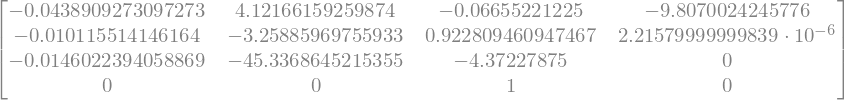

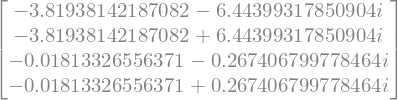

In [39]:
## Measure closed-loop stability near x_t using
## Lyapunov's Indirect Method

# Evaluate Jacobian to find A_eq (open loop)
Aeq = f.jacobian(x)\
.subs([(x1,xt[0]),(x2,xt[1]),(x3,xt[2]),(x4,xt[3])])\
.subs([(u1,ut[0]),(u2,ut[1])])

Beq = f.jacobian(u)\
.subs([(x1,xt[0]),(x2,xt[1]),(x3,xt[2]),(x4,xt[3])])\
.subs([(u1,ut[0]),(u2,ut[1])])

# Get numerical forms of matrices for convenience
Aeq_num = np.matrix(Aeq).astype(np.float64)
eig_Aeq = sym.Matrix(list(Aeq.eigenvals(rational=False).keys()))

# Print A
display(sym.symbols('Aeq'), Aeq)

# Print eigenvalues of A
display(sym.symbols('Eigenvalues'), eig_Aeq)

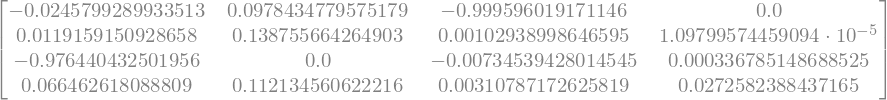

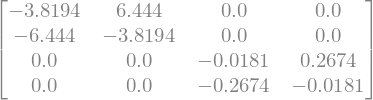

In [40]:
# Construct block modal form of Aeq
evals, evecs = np.linalg.eig(Aeq_num)
P = np.matrix(np.column_stack((evecs[:,0].real, evecs[:,0].imag,\
                evecs[:,2].real, evecs[:,2].imag)))
Aeq_modes = (P.getI()*Aeq_num*P).round(decimals=4)

# Print P, Az
display(sym.symbols('P'),sym.Matrix(P))
display(sym.symbols('A_{eq_z}'), sym.Matrix(Aeq_modes))

## Analysis: Oscillatory Modes

Chakraborty et al describe two oscillatory modes within the GTM longitudinal dynamics \[1\].

* Phugoid (slower oscillation, involves $x_1$ and $x_4$)

* Short period (faster oscillation, involves $x_2$ and $x_3$)

We want to measure how robust each mode is to perturbations. To simplify calculations, we can use approximations to __decouple__ the two nonlinear modes.

## Analysis: Decoupling Nonlinear Oscillatory Modes

The short period mode primarily involves $x_2$, $x_3$, and $u_1$. We can _approximately_ decouple the short period mode by holding all other states and inputs at trim conditions.

$$ g(x_2,x_3,u_1) = \begin{bmatrix} f_2(x_{1,t}, x_2, x_3, x_{4,t}, u_1, u_{2,t}) \\ f_3(x_{1,t}, x_2, x_3, x_{4,t}, u_1, u_{2,t}) \end{bmatrix} $$ 


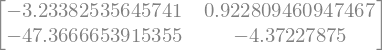

In [17]:
## Add decoupled short period dynamics

# Decoupled short period dynamics
g = sym.Matrix([[f2],[f3]])

# Numerical function for g(x,ut)
def g_sim(_x2,_x3, _u1, _xt, _ut):
    return [
        f2_sim(_xt[0],_x2,_x3,_xt[3],_u1,_ut[1]),
        f3_sim(_xt[0],_x2,_x3,_xt[3],_u1,_ut[1])
    ]

# Linearize about trim condition
Ag = g.jacobian(x[1:3])\
.subs([(x1,xt[0]),(x2,xt[1]),(x3,xt[2]),(x4,xt[3])])\
.subs([(u1,0),(u2,0)])

# Numerical form for convenience
Ag_num = np.matrix(Ag).astype(np.float64)
display(sym.symbols('Ag'),Ag)


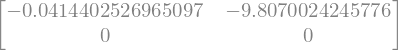

In [18]:
## Add decoupled phugoid dynamics

# Decoupled short period dynamics
h = sym.Matrix([[f1],[f4]])

# Numerical function for h(x,ut)
def h_sim(_x1,_x4, _u2, _xt, _ut):
    return [
        f1_sim(_x1,_xt[1], _xt[2], _x4, _ut[0], _u2),
        f4_sim(_x1,_xt[1], _xt[2], _x4, _ut[0], _u2),
    ]

# Linearize about trim condition
Ah = h.jacobian([x[0],x[3]])\
.subs([(x1,xt[0]),(x2,xt[1]),(x3,xt[2]),(x4,xt[3])])\
.subs([(u1,0),(u2,0)])

# Numerical form for convenience
Ah_num = np.matrix(Ah).astype(np.float64)
display(sym.symbols('Ah'),Ah)

In [19]:
## Functions for computing short period trajectories

def short_period_dynamics(t, x, xt, ut):
    return [
        f1_sim(x[0], x[1], x[2], x[3], ut[0], ut[1]),
        f2_sim(x[0], x[1], x[2], x[3], ut[0], ut[1]),
        f3_sim(x[0], x[1], x[2], x[3], ut[0], ut[1]),
        f4_sim(x[0], x[1], x[2], x[3], ut[0], ut[1])
    ]    

def decoupled_short_period_dynamics(t,x_2_3, xt, ut):
    return [
        f2_sim(xt[0], x_2_3[0], x_2_3[1], xt[3], ut[0], ut[1]),
        f3_sim(xt[0], x_2_3[0], x_2_3[1], xt[3], ut[0], ut[1])
    ]

def linear_short_period_dynamics(t,x_2_3, xt, ut):
    return [
        Ag_num.item(0,0) * x_2_3[0] + Ag_num.item(0,1) * x_2_3[1],
        Ag_num.item(1,0) * x_2_3[0] + Ag_num.item(1,1) * x_2_3[1]
    ]

def short_period_trajectory(ic1, ic2, xt, ut, worker_index=0, trajectories=None):
    traj = sci.integrate.solve_ivp(
        short_period_dynamics, 
        [0, 100], 
        [xt[0], xt[1] + ic1, xt[2]+ ic2, xt[3]],
        t_eval=np.linspace(0,100,10000),
        args=(xt,ut))
    
    if not trajectories is None:
        trajectories[worker_index] = traj
    
    return traj

def decoupled_short_period_trajectory(ic1, ic2, xt, ut, worker_index=0, trajectories=None):
    traj = sci.integrate.solve_ivp(
        decoupled_short_period_dynamics, 
        [0, 100], 
        [xt[1] + ic1, xt[2]+ ic2],
        t_eval=np.linspace(0,100,10000),
        args=(xt,ut))
    
    if not trajectories is None:
        trajectories[worker_index] = traj
    
    return traj

def linear_short_period_trajectory(ic1, ic2, xt, ut, worker_index=0, trajectories=None):
    traj = sci.integrate.solve_ivp(
        linear_short_period_dynamics, 
        [0, 100], 
        [ic1, ic2],
        t_eval=np.linspace(0,100,10000),
        args=(xt,ut))
    
    if not trajectories is None:
        trajectories[worker_index] = traj
    
    return traj
    

In [20]:
## Functions for computing phugoid trajectories

def phugoid_dynamics(t, x, xt, ut):
    return [
        f1_sim(x[0], x[1], x[2], x[3], ut[0], ut[1]),
        f2_sim(x[0], x[1], x[2], x[3], ut[0], ut[1]),
        f3_sim(x[0], x[1], x[2], x[3], ut[0], ut[1]),
        f4_sim(x[0], x[1], x[2], x[3], ut[0], ut[1])
    ]    

def decoupled_phugoid_dynamics(t,x_1_4, xt, ut):
    return [
        f2_sim(x_1_4[0], xt[1], xt[2], x_1_4[1], ut[0], ut[1]),
        f3_sim(x_1_4[0], xt[1], xt[2], x_1_4[1], ut[0], ut[1])
    ]

def linear_phugoid_dynamics(t,x_1_4, xt, ut):
    return [
        Ah_num.item(0,0) * x_1_4[0] + Ag_num.item(0,1) * x_1_4[1],
        Ah_num.item(1,0) * x_1_4[0] + Ag_num.item(1,1) * x_1_4[1]
    ]

def phugoid_trajectory(ic1, ic2, xt, ut, worker_index=0, trajectories=None):
    traj = sci.integrate.solve_ivp(
        phugoid_dynamics, 
        [0, 100], 
        [xt[0] + ic1, xt[1], xt[2], xt[3] + ic2],
        t_eval=np.linspace(0,100,10000),
        args=(xt,ut))
    
    if not trajectories is None:
        trajectories[worker_index] = traj
    
    return traj

def decoupled_phugoid_trajectory(ic1, ic2, xt, ut, worker_index=0, trajectories=None):
    traj = sci.integrate.solve_ivp(
        decoupled_phugoid_dynamics, 
        [0, 100], 
        [xt[0] + ic1, xt[3]+ ic2],
        t_eval=np.linspace(0,100,10000),
        args=(xt,ut))
    
    if not trajectories is None:
        trajectories[worker_index] = traj
    
    return traj

def linear_phugoid_trajectory(ic1, ic2, xt, ut, worker_index=0, trajectories=None):
    traj = sci.integrate.solve_ivp(
        linear_phugoid_dynamics, 
        [0, 100], 
        [ic1, ic2],
        t_eval=np.linspace(0,100,10000),
        args=(xt,ut))
    
    if not trajectories is None:
        trajectories[worker_index] = traj
    
    return traj
    

In [21]:
## Functions for computing trajectories

# Compute trajectory from single IC
def compute_mode_trajectory(function, ic, xt, ut):
    return {0:function(ic[0],ic[1],xt,ut)}

# Compute trajectories from multiple IC
def compute_mode_trajectories(function, ic, xt, ut):
    ## Code below copied, slightly modified from
    ## https://stackoverflow.com/questions/10415028/
    
    # Create list of all combinations of ICs
    # https://stackoverflow.com/questions/12935194/
    all_ic = list(itertools.product(ic,ic)) 
    
    manager = multiprocessing.Manager()
    trajectories = manager.dict()
    jobs = []

    for i in range(len(all_ic)):
        p = multiprocessing.Process(
            target=function,
            args = (all_ic[i][0], 
                    all_ic[i][1], 
                    xt, 
                    ut, 
                    i, 
                    trajectories))
        jobs.append(p)
        p.start()

    for proc in jobs:
        proc.join()
        
    return trajectories

In [22]:
## Construct phase portrait for short-period
## dynamics (decoupled and full polynomial)

ic = [0.1, -0.1]
full_trajectories_dict = compute_mode_trajectories(
    short_period_trajectory, ic, xt, ut)
decoupled_trajectories_dict = compute_mode_trajectories(
    decoupled_short_period_trajectory, ic, xt, ut)

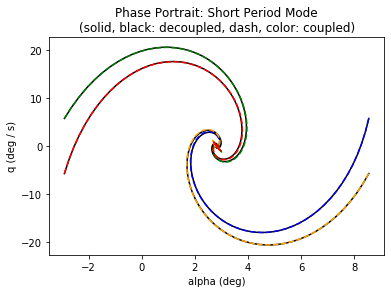

In [23]:
## Plot phase portraits in one plot

# Contains plot objects, used for legend
color_list = ['blue', 'orange', 'green', 'red', 'yellow']

plt.figure()

# Plot decoupled trajectories (solid)
for i in range(len(decoupled_trajectories_dict)):
    traj = decoupled_trajectories_dict[i]
    alpha = traj.y[0] * units.rad
    q = traj.y[1] * units.rad / units.s
    plt.plot(alpha.to(units.deg), q.to(units.deg/units.s), color='black',linestyle='-')

# Plot full trajectories (dashed)
for i in range(len(full_trajectories_dict)):
    traj = full_trajectories_dict[i]
    alpha = traj.y[1] * units.rad
    q = traj.y[2] * units.rad / units.s
    plt.plot(alpha.to(units.deg), q.to(units.deg/units.s), color=color_list[i],linestyle='--')

# Add title, legend, axis labels
plt.title('Phase Portrait: Short Period Mode\n(solid, black: decoupled, dash, color: coupled)')
plt.xlabel('alpha (deg)')
plt.ylabel('q (deg / s)')

plt.savefig('media/fig3/fig3_redo.png');
plt.show()

# Save plot to file (repeat of Fig.3 [1])


### Phase Portrait - Short Period Mode

|Re-created|Published \[1\]|
|-|-|
|<img src="media/fig3/fig3_redo.png" width=500/>|<img src="media/fig3/fig3_published.png" width=500/>|

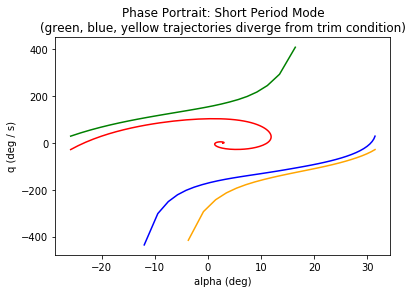

In [24]:
## Construct phase portrait for short-period
## dynamics (decoupled outside ROA)

# Calculate trajectories
ic = [0.5, -0.5]
div_trajectories_dict = compute_mode_trajectories(
    decoupled_short_period_trajectory, ic, xt, ut)

# Plot trajectories
plt.figure()
color_list = ['blue', 'orange', 'green', 'red', 'yellow']
for i in range(len(div_trajectories_dict)):
    traj = div_trajectories_dict[i]
    alpha = traj.y[0] * units.rad
    q = traj.y[1] * units.rad / units.s
    plt.plot(alpha.to(units.deg), q.to(units.deg/units.s), color=color_list[i],linestyle='-')

    # Add title, legend, axis labels
plt.title('Phase Portrait: Short Period Mode\n(green, blue, yellow trajectories diverge from trim condition)')
plt.xlabel('alpha (deg)')
plt.ylabel('q (deg / s)')

# Save plot to file (modified Fig.3 [1])
plt.savefig('media/fig3/fig3_redo_divergent.png');
plt.show()

### Divergent Trajectories

Note, this trim condition is asympotically stable, but __not globally__ asymptotically stabe.

<img src="media/fig3/fig3_redo_divergent.png" width=500/>

### ROA Estimation Setup: Two Final Model Modifications

1. The ROA computations require the equilibrium point at the origin, so we re-define the state $z = x - x_t$ "to shift the trim condition to the origin of the state space" \[1\].

$$ z = \begin{bmatrix}
    z_1 \\ z_2 \\ z_3 \\ z_4 
    \end{bmatrix} = x - x_t = \begin{bmatrix}
    V-V_t \\ \alpha - \alpha_t \\ q - q_t \\ \theta - \theta_t
    \end{bmatrix}
$$ 

2. Polynomial terms with degree greater than 5, and/or coefficients less that $10^{-6}$ were removed.

### ROA Estimation Setup: Two New Definitions


Two new definitions are needed for the proposed ROA estimation method:

1. Define "shape function" $p(z) = z^T N z$ for some $n \times n$ symmetric matrix $N$.

2. Define "level set" $\epsilon_\beta = \{ z \in \mathcal{R}^n : p(z) \leq \beta \}$.


Here, the ellipsoid is $\epsilon_\beta$. The shape of the ellipsoid is $p(z)$, and the size of the ellipsoid is $\beta$.


We want to solve for the largest $\epsilon_\beta$ within the ROA. This is difficult, so instead we will solve for upper and lower bounds.


### ROA Estimate: Upper Bound

The steps to solve for the best ROA upper bound involve searching for divergent trajectories: \[1\]

1. Guess at a large ROA ellipsoid size $\beta$

2. Pick a random initial condition that lies on the edge of that ellipse

3. When a a random initial condition causes the trajectory to diverge from the trim condition, reduce your ellipse size guess and try again

4. Repeat until the pre-set max number of iterations is reached

### ROA Estimate: Upper Bound

Written mathematically... \[1\]

1. Choose a large ROA size $\beta_{try}$

2. Choose an initial condition $z_0$ that satisfies $p(z_0) = \beta_{try}$

3. If $z_0$ produces a divergent trajectory, reduce $\beta_{try}$ by a factor of $0.995$ and __return to step 1__. Otherwise, choose a different $z_0$ which satisfies $p(z_0) = \beta_{try}$

4. Repeat until the pre-set max number of iterations is reached

### ROA Estimate: Lower Bound

|Lemma 1 \[4\]|
|-|
| <img src=media/lemma1/lemma1.png width=500 /> |

### ROA Estimate: Lower Bound

The steps to solve for the best ROA lower bound involve combining Lyapunov stability theory with a specific constrained optimization problem: \[1\]

Given a Lyapunov function $V(z)$, we are looking for:

$$ \gamma^* := \text{max}\gamma \ \text{ subject to: } \ \Omega_\gamma\ \subset \{ z \in \mathbb{R}^n : \Delta V(z)f(z) < 0 \} \tag{27} $$

$$ \underline{\beta} := \text{max}\beta \ \text{ subject to: } \ \epsilon_\beta \subset \Omega_\gamma \tag{28} $$

These "set containment constraints" can be replaced with "a sufficient condition involving non-negative functions" \[1\].

### ROA Estimate: Lower Bound

A sufficient condition for the $\underline{\beta}$ constaint turns this into a sum-of-squares ($h = g_1^2 + ... + g_n^2$) optimization problem: \[1\]

$$ \underline{\beta} := \text{max}\beta \ \text{ subject to } \ s(z) \ \text{ is SOS, and } \\ -(\beta - p(z)s(z) + (\gamma^* - V(z)) \ \text{ is SOS } \tag{30} $$ 

Here, $s(z)$ "is a decision variable of the optimization" \[1\].

### ROA Estimate: Lower Bound

But how do we find a Lyapunov function?

Because the origin is asymptotically stable, we can use linearization: \[1\]

$$ V_{LIN}(z) := z^T P z,\ \ \text{ where } A^T P + P A = -I $$ 

It turns out that this often results in a conservative ROA lower bound estimate \[1\]. So how do we find a _better_ Lyapunov function?

### ROA Estimate: Lower Bound

To find a better Lyapunov function, we can perform the $V$-$s$ iteration steps below (starting with $V_{LIN}$, and with $l_1 (z) = -\epsilon_1 z^t z$ and $l_2(z) = -\epsilon_2 z^t z, for \epsilon_1,\ \epsilon_2 \approxeq 10^{-6}$): \[1\]

<img src=media/v-s/vs_steps.png width=500 />

### Final ROA Estimate

|Figure 8 \[1\]|
|-|
|<img src=media/v-s/result/final_roa.png width=500 />|

### Conclusion: Nonlinear Analysis is Hard

* Linear analysis and high-fidelity simulations can still miss important dynamical elements

* A larger ROA can imply a higher robustness to perturbations

* There are algorithms to help find better Lyapunov functions, for the purposes of ROA estimation



### References
\[1\] Chakraborty, Abhijit, Peter Seiler, and Gary J. Balas. "Nonlinear region of attraction analysis for flight control verification and validation." Control Engineering Practice 19, no. 4 (2011): 335-345.

\[2\] Chakraborty, Abhijit, Peter Seiler, and Gary J. Balas. "Susceptibility of F/A-18 flight controllers to the falling-leaf mode: Nonlinear analysis." Journal of guidance, control, and dynamics 34, no. 1 (2011): 73-85.

\[3\] Khalil, Hassan K., and Jessy W. Grizzle. Nonlinear systems. Vol. 3. Upper Saddle River, NJ: Prentice hall, 2002.

\[4\] Vidyasagar, Mathukumalli. Nonlinear systems analysis. Vol. 42. Siam, 2002.

\[5\] https://www.nasa.gov/larc/airstar-for-the-sake-of-pilots-and-passengers

\[6\] https://mathworld.wolfram.com/LeastSquaresFitting.html

\[7\] https://dept.aem.umn.edu/~AerospaceControl/

\[8\] https://www.cds.caltech.edu/sostools/